In [ ]:
import sqlite3
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

conn = sqlite3.connect("moderation_data_updated.db")
df = pd.read_sql_query("SELECT * FROM moderation", conn)
conn.close()

models = ["distilbert", "roberta", "logreg", "naive_bayes"]
df["actual_flag"] = df["actual_label"].apply(lambda x: 1 if str(x).lower() == "toxic" else 0)

results = {}

for model in models:
    y_true = df["actual_flag"]
    y_pred = df[f"flagged_{model}"].astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    latency_column = f"{model}_latency"
    average_latency = df[latency_column].mean() * 1000 

    results[model] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "False Positive Rate (FPR)": fpr,
        "False Negative Rate (FNR)": fnr,
        "Average Latency (ms)": average_latency  
    }

results_df = pd.DataFrame(results).T
results_df["Average Latency (ms)"] = results_df["Average Latency (ms)"].apply(lambda x: round(x, 3))
pd.set_option("display.float_format", "{:.3f}".format)

print(results_df)



             Accuracy  Precision  Recall  F1 Score  False Positive Rate (FPR)  \
distilbert      0.935      0.633   0.680     0.656                      0.039   
roberta         0.937      0.632   0.735     0.679                      0.043   
logreg          0.924      0.603   0.476     0.532                      0.031   
naive_bayes     0.928      0.718   0.347     0.468                      0.014   

             False Negative Rate (FNR)  Average Latency (ms)  
distilbert                       0.320               214.324  
roberta                          0.265                62.296  
logreg                           0.524                 2.835  
naive_bayes                      0.653                 0.671  


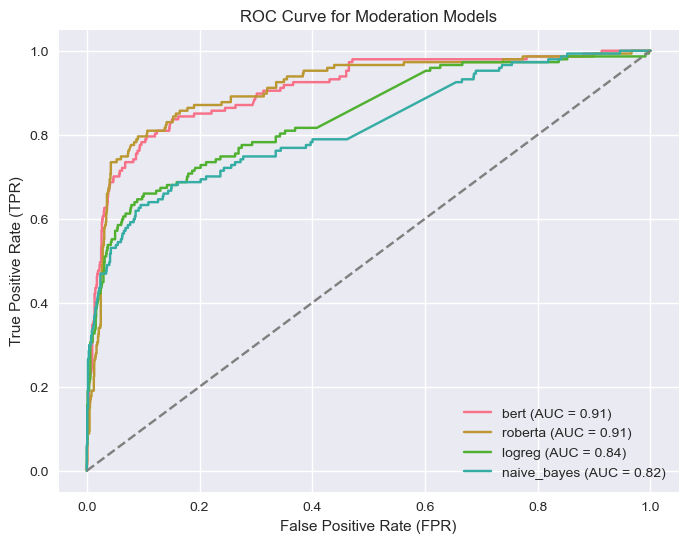

In [44]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conn = sqlite3.connect("moderation_data_updated.db")

query = """
SELECT actual_label, distilbert_score, roberta_score, logreg_score, naive_bayes_score 
FROM moderation 
WHERE actual_label IN ('toxic', 'not_toxic')
"""
df = pd.read_sql_query(query, conn)

df["actual_label"] = df["actual_label"].map({"toxic": 1, "not_toxic": 0})

models = ["distilbert", "roberta", "logreg", "naive_bayes"]

plt.figure(figsize=(8, 6))

for model in models:
    y_true = df["actual_label"]  
    y_scores = df[f"{model}_score"]  

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    if model == "distilbert":
        label = "bert"
    else:
        label = model

    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})") 

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Moderation Models")
plt.legend(loc="lower right")

plt.show()

conn.close()


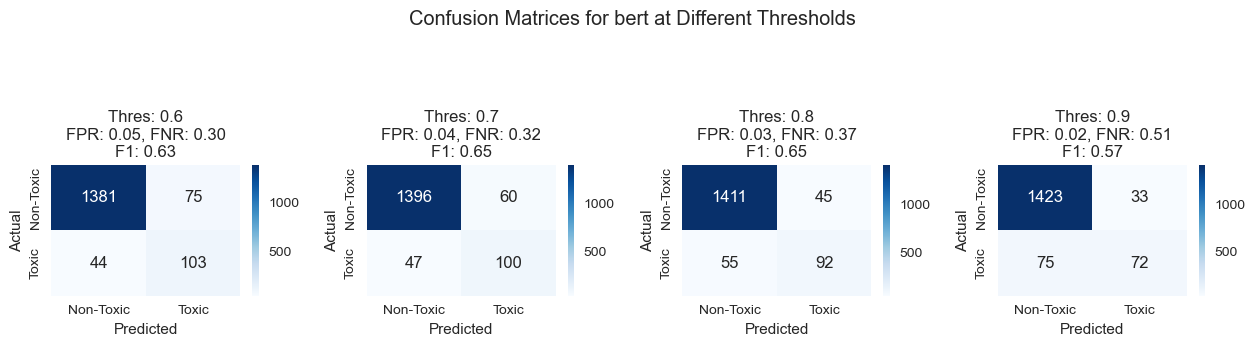

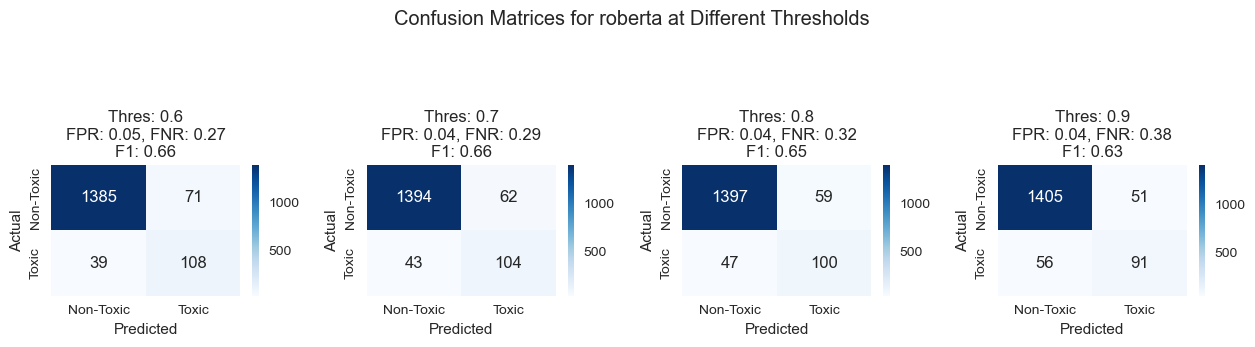

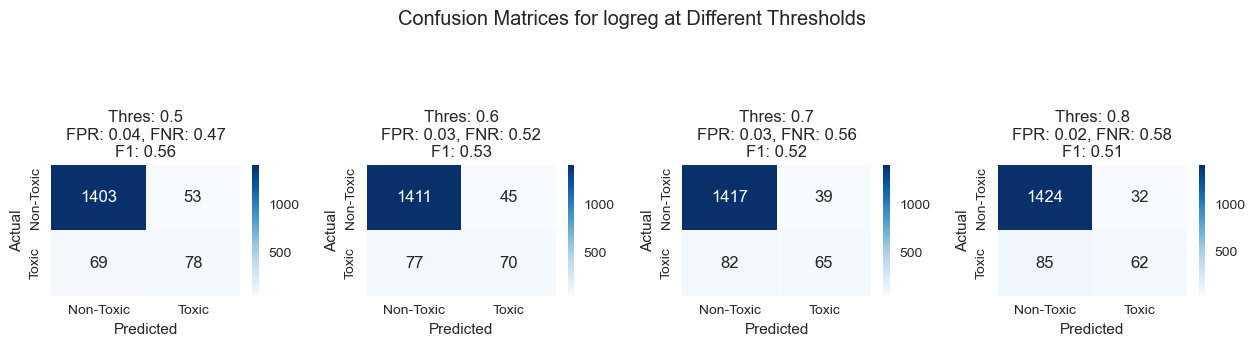

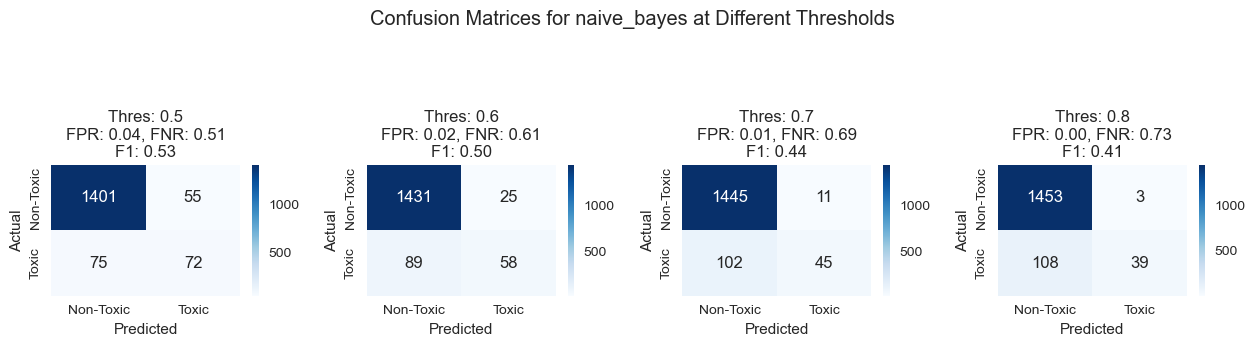

Best threshold for bert by F1: 0.72 (F1: 0.656)
Best threshold for roberta by F1: 0.65 (F1: 0.679)
Best threshold for logreg by F1: 0.48 (F1: 0.564)
Best threshold for naive_bayes by F1: 0.45 (F1: 0.542)


In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

conn = sqlite3.connect("moderation_data_updated.db")

query = """
SELECT actual_label, distilbert_score, roberta_score, logreg_score, naive_bayes_score 
FROM moderation 
WHERE actual_label IN ('toxic', 'not_toxic')
"""
df = pd.read_sql_query(query, conn)
df["actual_label"] = df["actual_label"].map({"toxic": 1, "not_toxic": 0})

models = {
    "bert": ("distilbert_score", [0.6, 0.7, 0.8, 0.9]),
    "roberta": ("roberta_score", [0.6, 0.7, 0.8, 0.9]),
    "logreg": ("logreg_score", [0.5, 0.6, 0.7, 0.8]),
    "naive_bayes": ("naive_bayes_score", [0.5, 0.6, 0.7, 0.8])
}

for model_name, (score_col, thresholds) in models.items():
    plt.figure(figsize=(len(thresholds) * 3.2, 3))
    plt.suptitle(f"Confusion Matrices for {model_name} at Different Thresholds", y=1.15)

    for i, threshold in enumerate(thresholds, 1):
        y_true = df["actual_label"]
        y_pred = (df[score_col] > threshold).astype(int)

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        f1 = f1_score(y_true, y_pred)
        fpr = fp / (fp + tn) if (fp + tn) else 0
        fnr = fn / (fn + tp) if (fn + tp) else 0

        plt.subplot(1, len(thresholds), i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Toxic', 'Toxic'],
                    yticklabels=['Non-Toxic', 'Toxic'])
        plt.title(f"Thres: {threshold}\nFPR: {fpr:.2f}, FNR: {fnr:.2f}\nF1: {f1:.2f}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

threshold_search = np.arange(0.0, 1.0, 0.01)
best_thresholds = {}

for model_name, (score_col, _) in models.items():
    best_thresh = 0
    best_f1 = 0

    for thresh in threshold_search:
        preds = (df[score_col] > thresh).astype(int)
        f1 = f1_score(df["actual_label"], preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    best_thresholds[model_name] = (best_thresh, best_f1)

for model_name, (thresh, f1) in best_thresholds.items():
    print(f"Best threshold for {model_name} by F1: {thresh:.2f} (F1: {f1:.3f})")

conn.close()
